In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_curve
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import random
random.seed(1)
from sklearn.linear_model import Lasso

/Users/GoViral/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


* The symptoms included are as follows:

In [2]:
symptoms = ['intercept',
            'fever',
            'sorethroat',
            'cough',
            'muscle',
            'headache',
            'fatigue',
            'vomit',
            'nausea',
            'diarrhea',
            'chills',
            'sneeze',
            'shortness of breath',
            'phlegm',
            'blockednose',
            'earache',
            'leg pain',
            'runnynose',
            'virus']

In [3]:
print(symptoms)

['intercept', 'fever', 'sorethroat', 'cough', 'muscle', 'headache', 'fatigue', 'vomit', 'nausea', 'diarrhea', 'chills', 'sneeze', 'shortness of breath', 'phlegm', 'blockednose', 'earache', 'leg pain', 'runnynose', 'virus']


In [4]:
def read_file(filename):
    data = pd.read_csv(filename)
    data['intercept'] = 1
    columns = list(data.columns)
    columns = columns[-1:] + columns[:-1]
    data = data[columns]
#     train_data = data.drop(['virus'],axis =1).as_matrix()
    return data

In [5]:
def read_parameters(filename):
    parameters = pd.read_csv(filename)
    return parameters

#### Get the parameters for the different dataset combinations

In [6]:
directory_ = "./Generated_Parameters_5/"
with_demographics_ = ['with_demographics_nyumc.csv','with_demographics_goviral.csv','with_demographics_fluwatch.csv','with_demographics_hongkong.csv','with_demographics_hutterite.csv']
with_demographic_parameters = defaultdict()

In [7]:
def return_parameters(file,parameters_of):
    param = read_parameters(file)
    parameter_dict = defaultdict()
    for i in parameters_of:
        parameter_dict[i] = list(param[i])
    return parameter_dict
    

In [8]:
def get_parameters(dataset_name,parameters):
    return np.array(list(parameters[dataset_name]))

In [9]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [10]:
def get_results(param,sample_points):
    return sigmoid(np.dot(param,sample_points.T)  )

In [11]:
def save_results_for_finding_threshold(filename,dataframe,predicted):
    results = pd.DataFrame()
    results['Actual'] = dataframe['virus']
    results['Predicted'] = predicted
    print(results.head())
    results.to_csv(filename,index = False)

In [12]:
def get_all_datasets(training_data_,training_directory):
    datasets = defaultdict()
    for i in training_data_:
        data = read_file(training_directory+i)
        datasets[i[:-4]] = (data)
    return datasets

In [13]:
def get_all_results(data_dict,param):
    results = defaultdict()
    for i in list(param.keys()):
        data,train = data_dict[i]
        results[i] = get_results(param[i],train)
    return results

In [14]:
def result_statistics(list_):
#     print("Min : ",min(list_))
#     print("Max : ",max(list_))
#     print("Mean : ",np.mean(list_))
#     print("Standard Deviation : ",np.std(list_))
    return min(list_),max(list_)

In [15]:
def return_class(threshold,list_):
    ans = [1 if x >= threshold else 0 for x in list_]
    return ans

def metrics_pred(list1,list2):
    f1 =f1_score(list1,list2)
    precision = precision_score(list1,list2)
    recall = recall_score(list1,list2)
    accuracy = accuracy_score(list1,list2)
    fpr,tpr,threshold = roc_curve(list1,list2)
    auc = metrics.auc(fpr,tpr)
#     print("f1 score : ",f1)
#     print("Precision score : ",precision)
#     print("Recall : ",recall)
#     print("Accuracy : ",accuracy)
#     print("Area under the curve : ",auc)
    return auc

In [16]:
def find_threshold(min_,max_,list1,list2,step_size = 1e-3):
    auc_thresholds = defaultdict()
    value = min_
    while value < max_:
        auc_thresholds[value] = metrics_pred(list1,return_class(value,list2))
        value += step_size
    optimal_threshold = max(auc_thresholds.items(), key=lambda x: x[1]) 
    return optimal_threshold

In [17]:
def get_threshold(pred,true):
    min_,max_ = result_statistics(pred)
    threshold = find_threshold(min_,max_,true,pred)
    return threshold

In [18]:
def return_all_thresholds(results,data,y_true):
    thresholds = defaultdict()
    for i in list(data.keys()):
        print("_____________________")
        min_,max_ = result_statistics(results[i])
        
        threshold = find_threshold(min_,max_,y_true[i],results[i])
        print("Found threshold for : ",i)
        thresholds[i] = threshold
    return thresholds

In [19]:

def test(filename_,param,thresholds_):
    aucs = defaultdict()
    data,train = read_file(filename_)
    for i in list(param.keys()):
        test_results = get_results(param[i],train)
        auc_ = metrics_pred(data['virus'],return_class(thresholds_[i][0],test_results))
        aucs[i] = auc_
    return aucs

In [20]:
def return_final_auc_scores(training_data_,training_directory,filename_,parameters):
    data = get_all_datasets(training_data_)
    results = get_all_results(data,parameters)
    #find the thresholds
    thresholds = return_all_thresholds(results,data)
    #get the auc values
    aucs_= test(filename_,parameters,thresholds)
    return aucs_


In [21]:
def create_dict(dict_):
    temp = []
    for k,v in dict_.items():
        temp.append((k,v))
    return temp
        

In [22]:
results_symp = defaultdict()
results_demo = defaultdict()

#### Get the symptoms

In [23]:
def get_gender(dataframe_):
    df = dataframe_[['male','female']]
    temp = df.apply(lambda x:x.argmax(),axis =1)
    return temp

In [24]:
def get_age(dataframe_):
    df = dataframe_[['age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+']]
    temp = df.apply(lambda x: x.argmax(), axis=1)
    return temp

In [25]:
def get_predictions(name,train,param_dict,temp_age,temp_gender,collection_mode = 'clinically_collected',population ='population'):
    results = []
    for i in range(train.shape[0]):
        sample_point = train[i,:]
        p_data = get_results(param_dict[name],sample_point)
        p_collection = get_results(param_dict[collection_mode],sample_point)
        p_gender = get_results(param_dict[temp_gender[i]],sample_point)
        p_age = get_results(param_dict[temp_age[i]],sample_point)
        p_population = get_results(param_dict[population],sample_point)
        result = [p_data,p_collection,p_gender+p_age,p_population]
        results.append(result)
    return results
    

In [26]:
def get_coeff(X,Y):
    lm = linear_model.LogisticRegression()
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 10)
    lm.fit(x_train,y_train)
    y_pred = lm.predict(x_test)
    acc = accuracy_score(y_test,y_pred)
#     print("Accuracy :",acc)
    fpr,tpr,threshold = roc_curve(y_test,y_pred)
    auc_score = metrics.auc(fpr,tpr)
#     print("AUC :",auc_score)
    coefficients = lm.coef_.tolist()[0]
    print("Coefficients : ",coefficients)
    intercept = lm.intercept_.tolist()[0]
    return coefficients,intercept
    

In [27]:
def norm(list_):
    min_ = min(list_)
    max_ = max(list_)
    denom = max_ - min_
    ans = [x-min_/denom for x in list_]
    return ans

In [28]:
COLLECTION_MODE = {'nyumc':'clinically_collected',
                   'goviral':'individually_reported',
                   'fluwatch':'individually_reported',
                   'hongkong': 'health_worker',
                   'hutterite':'health_worker'}

In [29]:
def process(training_data_list,training_directory,filename_,parameters,collection_mode = COLLECTION_MODE):
    name_dataset = filename_.split('/')[-1]
    thresholds = defaultdict()
    print(name_dataset)
    data = get_all_datasets(training_data_list,training_directory)
    print("Got the data")
    print("Now finding coefficients for the the datasets!")
    weights = defaultdict()
    for i in data.keys():
        print("Analyzing the dataset : ",i)
        data_ = data[i]
        temp_age = get_age(data_)
        temp_gender = get_gender(data_)
        only_symp_data = data_[symptoms]
        only_symp_data.drop('virus',axis = 1,inplace = True)
        train_data_symp = only_symp_data.as_matrix()
        prediction = get_predictions(i,train_data_symp,parameters,temp_age,temp_gender,COLLECTION_MODE[i])
        temp = [i[1:] for i in prediction]
        first = [i[0] for i in prediction]
        y_true = list(data_['virus'])
        coefficient,intercept = get_coeff(temp,y_true)
        weights[i] = (coefficient,intercept)
        value = np.array(np.dot(temp,np.array(weights[i][0]).T)+weights[i][1]+first)
        values = [sigmoid(j) for j in value]
        threshold = get_threshold(values,y_true)
        print("Found threshold for ",i)
        thresholds[i] = threshold[0]
    return weights,thresholds

In [30]:
def process_test(training_directory,filename_,parameters,weights,thresholds,collection_mode = COLLECTION_MODE):
    aucs_ = defaultdict()
    predictions = defaultdict()
    test_data = get_all_datasets([filename_],training_directory)
    name = filename_.split('.')[0]
    print("Name : ",name) 
    data_ = test_data[name]
    temp_age = get_age(data_)
    temp_gender = get_gender(data_)
    only_symp_data = data_[symptoms]
    only_symp_data.drop('virus',axis = 1,inplace = True)
    y_true = list(data_['virus'])
    train_data_symp = only_symp_data.as_matrix()
    for i in weights.keys():
        print("Using the parameters of : ",i)
        prediction = get_predictions(i,train_data_symp,parameters,temp_age,temp_gender,COLLECTION_MODE[i])
        temp = [i[1:] for i in prediction]
        first = [i[0] for i in prediction]
        prediction = np.array(temp)
        value = np.array(np.dot(temp,np.array(weights[i][0]).T)+weights[i][1]+first)
        values = [sigmoid(i) for i in value]
        predictions[i] = values
    print("Got the predicitions from the different parameters")
    for i in weights.keys():
        auc_ = metrics_pred(y_true,return_class(0.5,predictions[i]))
        aucs_[i] = auc_
        print("Found the auc for ",i)
    return aucs_
#         

#### With demographics

##### Generating the results for NYUMC

In [31]:
training_data_nyumc = ['goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = 'nyumc.csv'

In [33]:
cols = ['goviral', 'fluwatch', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population']
demo_nyumc = return_parameters(directory_+'with_demographics_nyumc.csv',cols)
demo_nyumc.keys()

dict_keys(['goviral', 'fluwatch', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population'])

In [34]:
print("With demographics!")

With demographics!


In [35]:
weights_nyumc,thresholds_nyumc = process(training_data_nyumc,training_directory,filename_,demo_nyumc)

nyumc.csv
Got the data
Now finding coefficients for the the datasets!
Analyzing the dataset :  goviral
Coefficients :  [1.7804687836382829, 0.9903404994628964, 0.49210973368842253]
Found threshold for  goviral
Analyzing the dataset :  fluwatch
Coefficients :  [3.6002263205814393, -0.5833885771751752, -0.24733567837407258]
Found threshold for  fluwatch
Analyzing the dataset :  hongkong
Coefficients :  [2.800726996951084, 3.7630469356578837, 1.8292613638742214]
Found threshold for  hongkong
Analyzing the dataset :  hutterite
Coefficients :  [0.4340984375076128, 1.728677270654941, 0.8837849178793492]
Found threshold for  hutterite


In [36]:
thresholds_nyumc

defaultdict(None,
            {'fluwatch': 0.68958687893539061,
             'goviral': 0.55932136542150801,
             'hongkong': 0.38493201175566061,
             'hutterite': 0.86745317123433607})

In [37]:
aucs_nyumc = process_test(training_directory,filename_,demo_nyumc,weights_nyumc,thresholds_nyumc)

Name :  nyumc
Using the parameters of :  goviral
Using the parameters of :  fluwatch
Using the parameters of :  hongkong
Using the parameters of :  hutterite
Got the predicitions from the different parameters
Found the auc for  goviral
Found the auc for  fluwatch
Found the auc for  hongkong
Found the auc for  hutterite


In [38]:
aucs_nyumc

defaultdict(None,
            {'fluwatch': 0.4998655536513622,
             'goviral': 0.53234643441561735,
             'hongkong': 0.65570361359093332,
             'hutterite': 0.53234643441561735})

##### Generating the results for Goviral

In [39]:
training_data_goviral = ['nyumc.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = 'goviral.csv'

In [40]:
cols = ['nyumc', 'fluwatch', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population']
demo_goviral = return_parameters(directory_+'with_demographics_goviral.csv',cols)
demo_goviral.keys()

dict_keys(['nyumc', 'fluwatch', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population'])

In [41]:
weights_goviral,thresholds_goviral = process(training_data_goviral,training_directory,filename_,demo_goviral)

goviral.csv
Got the data
Now finding coefficients for the the datasets!
Analyzing the dataset :  nyumc
Coefficients :  [3.297021407845064, 5.366582320280951, 2.6853594846944455]
Found threshold for  nyumc
Analyzing the dataset :  fluwatch
Coefficients :  [2.207455181004608, -0.32078090705612883, -0.15319870041512432]
Found threshold for  fluwatch
Analyzing the dataset :  hongkong
Coefficients :  [3.4686557091412267, 3.3773246240109693, 1.6928265637319764]
Found threshold for  hongkong
Analyzing the dataset :  hutterite
Coefficients :  [0.19734394764910618, 1.7967882057345528, 0.8973254911875315]
Found threshold for  hutterite


In [42]:
aucs_goviral1 = process_test(training_directory,filename_,demo_goviral,weights_goviral,thresholds_goviral)

Name :  goviral
Using the parameters of :  nyumc
Using the parameters of :  fluwatch
Using the parameters of :  hongkong
Using the parameters of :  hutterite
Got the predicitions from the different parameters
Found the auc for  nyumc
Found the auc for  fluwatch
Found the auc for  hongkong
Found the auc for  hutterite


In [43]:
aucs_goviral1

defaultdict(None,
            {'fluwatch': 0.5,
             'hongkong': 0.73375951019673158,
             'hutterite': 0.74840558831915249,
             'nyumc': 0.74288329656807572})


##### Generating the results for fluwatch

In [44]:
training_data_fluwatch = ['nyumc.csv','goviral.csv','hongkong.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = 'fluwatch.csv'

In [45]:
cols = ['nyumc', 'goviral', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population']
demo_fluwatch = return_parameters(directory_+'with_demographics_fluwatch.csv',cols)
demo_fluwatch.keys()

dict_keys(['nyumc', 'goviral', 'hongkong', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population'])

In [46]:
weights_fluwatch,thresholds_fluwatch = process(training_data_fluwatch,training_directory,filename_,demo_fluwatch)

fluwatch.csv
Got the data
Now finding coefficients for the the datasets!
Analyzing the dataset :  nyumc
Coefficients :  [3.98605513007818, 5.056194007966696, 2.5405727116343515]
Found threshold for  nyumc
Analyzing the dataset :  goviral
Coefficients :  [1.4701620502557506, 0.968853192449679, 0.48874404931832816]
Found threshold for  goviral
Analyzing the dataset :  hongkong
Coefficients :  [3.487376105653434, 3.3718348141097714, 1.6927452624725856]
Found threshold for  hongkong
Analyzing the dataset :  hutterite
Coefficients :  [0.1956587036411659, 1.7989600470646305, 0.8987939524494819]
Found threshold for  hutterite


In [47]:
aucs_fluwatch1 = process_test(training_directory,filename_,demo_fluwatch,weights_fluwatch,thresholds_fluwatch)

Name :  fluwatch
Using the parameters of :  nyumc
Using the parameters of :  goviral
Using the parameters of :  hongkong
Using the parameters of :  hutterite
Got the predicitions from the different parameters
Found the auc for  nyumc
Found the auc for  goviral
Found the auc for  hongkong
Found the auc for  hutterite


In [48]:
aucs_fluwatch1

defaultdict(None,
            {'goviral': 0.5950480447606884,
             'hongkong': 0.5676579699568205,
             'hutterite': 0.57466703156358334,
             'nyumc': 0.57034908471690082})

##### Generating the results for HongKong

In [49]:
training_data_hongkong = ['nyumc.csv','goviral.csv','fluwatch.csv','hutterite.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = 'hongkong.csv'

In [50]:
cols = ['nyumc', 'goviral', 'fluwatch', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population']
demo_hongkong = return_parameters(directory_+'with_demographics_hongkong.csv',cols)
demo_hongkong.keys()

dict_keys(['nyumc', 'goviral', 'fluwatch', 'hutterite', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population'])

In [51]:
weights_hongkong,thresholds_hongkong = process(training_data_hongkong,training_directory,filename_,demo_hongkong)

hongkong.csv
Got the data
Now finding coefficients for the the datasets!
Analyzing the dataset :  nyumc
Coefficients :  [4.118099411800898, 5.064155387773437, 2.3689742390323465]
Found threshold for  nyumc
Analyzing the dataset :  goviral
Coefficients :  [1.7531584695439208, 1.0189642482836625, 0.5352417543025902]
Found threshold for  goviral
Analyzing the dataset :  fluwatch
Coefficients :  [2.956499595478161, -0.3760896447472476, -0.08727297380236188]
Found threshold for  fluwatch
Analyzing the dataset :  hutterite
Coefficients :  [0.8151078535843728, 1.5740369429461913, 0.7505488743414308]
Found threshold for  hutterite


In [52]:
aucs_hongkong = process_test(training_directory,filename_,demo_hongkong,weights_hongkong,thresholds_hongkong)

Name :  hongkong
Using the parameters of :  nyumc
Using the parameters of :  goviral
Using the parameters of :  fluwatch
Using the parameters of :  hutterite
Got the predicitions from the different parameters
Found the auc for  nyumc
Found the auc for  goviral
Found the auc for  fluwatch
Found the auc for  hutterite


In [53]:
aucs_hongkong

defaultdict(None,
            {'fluwatch': 0.5,
             'goviral': 0.91523048826259745,
             'hutterite': 0.90945210620957229,
             'nyumc': 0.86701299289371514})

##### Generating results for hutterite

In [54]:
training_data_hutterite = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv']
training_directory = "../../Data/With_Improved_Target/With_Demographics/"
filename_ = 'hutterite.csv'

In [55]:
cols = ['nyumc', 'goviral', 'fluwatch', 'hongkong', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population']
demo_hutterite = return_parameters(directory_+'with_demographics_hutterite.csv',cols)
demo_hutterite.keys()

dict_keys(['nyumc', 'goviral', 'fluwatch', 'hongkong', 'clinically_collected', 'individually_reported', 'health_worker', 'female', 'male', 'age 0-4', 'age 5-15', 'age 16-44', 'age 45-64', 'age 65+', 'population'])

In [56]:
weights_hutterite,thresholds_hutterite = process(training_data_hutterite,training_directory,filename_,demo_hutterite)

hutterite.csv
Got the data
Now finding coefficients for the the datasets!
Analyzing the dataset :  nyumc
Coefficients :  [4.171124244532128, 5.055340094780124, 2.3699632368667527]
Found threshold for  nyumc
Analyzing the dataset :  goviral
Coefficients :  [1.571400218389747, 1.056060687364604, 0.552977501003548]
Found threshold for  goviral
Analyzing the dataset :  fluwatch
Coefficients :  [3.0902543531401143, -0.4230710738213154, -0.10176920592766257]
Found threshold for  fluwatch
Analyzing the dataset :  hongkong
Coefficients :  [4.307116136144691, 2.9269565232008783, 1.3157898195049644]
Found threshold for  hongkong


In [58]:
aucs_hutterite = process_test(training_directory,filename_,demo_hutterite,weights_hutterite,thresholds_hutterite)

Name :  hutterite
Using the parameters of :  nyumc
Using the parameters of :  goviral
Using the parameters of :  fluwatch
Using the parameters of :  hongkong
Got the predicitions from the different parameters
Found the auc for  nyumc
Found the auc for  goviral
Found the auc for  fluwatch
Found the auc for  hongkong


In [59]:
aucs_hutterite

defaultdict(None,
            {'fluwatch': 0.5,
             'goviral': 0.64385201837552541,
             'hongkong': 0.75427750541440108,
             'nyumc': 0.74403387022928247})

In [60]:
aucs_ = defaultdict()
aucs_['nyumc'] = aucs_nyumc
aucs_['goviral'] = aucs_goviral1
aucs_['fluwatch'] = aucs_fluwatch1
aucs_['hongkong'] = aucs_hongkong
aucs_['hutterite'] = aucs_hutterite

In [61]:
aucs_

defaultdict(None,
            {'fluwatch': defaultdict(None,
                         {'goviral': 0.5950480447606884,
                          'hongkong': 0.5676579699568205,
                          'hutterite': 0.57466703156358334,
                          'nyumc': 0.57034908471690082}),
             'goviral': defaultdict(None,
                         {'fluwatch': 0.5,
                          'hongkong': 0.73375951019673158,
                          'hutterite': 0.74840558831915249,
                          'nyumc': 0.74288329656807572}),
             'hongkong': defaultdict(None,
                         {'fluwatch': 0.5,
                          'goviral': 0.91523048826259745,
                          'hutterite': 0.90945210620957229,
                          'nyumc': 0.86701299289371514}),
             'hutterite': defaultdict(None,
                         {'fluwatch': 0.5,
                          'goviral': 0.64385201837552541,
                          'hongkong':

In [62]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
#     df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label},fmt="f")
    ax.set_title(title)
    ax.set_xlabel('Predicted using datatset')
    plt.show()
    
    return df

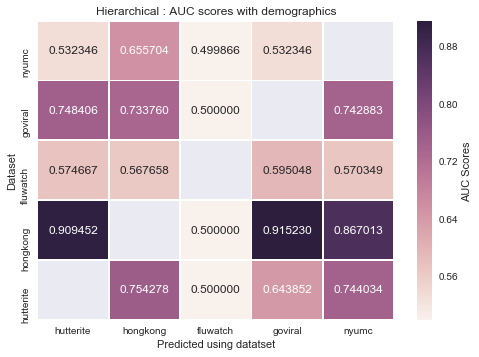

In [63]:
nyumc = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'], 
                     aucs_, 
                     'Dataset',
                     ['hutterite','hongkong','fluwatch','goviral','nyumc'],'AUC Scores ','Hierarchical : AUC scores with demographics')

In [ ]:
aucs_